## 목적
- training 기간이 오래전일 경우 성능의 차이가 있는지?
- 큰 차이가 없다면 매달 모델을 재학습 시킬 필요가 없음
    - 매달 재학습 하는데 cost가 많이 드는가? -> ???
- 몇 개월을 주기로 재학습 하는게 가장 효율적인지? 매달 / 분기별 / 반기별 / 캠페인 시작시 등등

## 설계 - 2가지 방법
1.  train 기간 고정, test 기간 변경
    - train: input(1월), label(2월)
    - test: input(2,3,4,5), label(3,4,5,6)
2.  train 기간 변경, test 기간 고정
    - train: input(1,2,3,4), label(2,3,4,5)
    - test: input(5), label(6)

- split: 8:2
- sampling: 20%
- model: lightgbm
- evaluation: auprc

## package

In [47]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
from sm_utils import sampling, evaluate, show_results, save_model, load_model, make_train_data,  make_test_data

In [49]:
DATA_PATH = '/home/dmig/work/upsell/data/'
RESULT_PATH = '/home/dmig/work/upsell/result/training_preriod/'

## 실험 1
- train 기간 고정, test 기간 변경
- train: input(1월), label(2월)
- test: input(2,3,4,5), label(3,4,5,6)

### TRAIN
- 1월 데이터로 모델 학습

In [52]:
# load data
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart01.shape

(18176215, 81)

In [53]:
# make train data
result = make_train_data(df_mart01)
result.keys()

make_train_data +++
label/sample:  0.2
sample/total:  0.09245956872759263
make_data_for_modeling---


dict_keys(['trn', 'val'])

In [54]:
result['trn'].keys()

dict_keys(['idx', 'x', 'y'])

In [58]:
trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']


val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

trn_idx.shape, x_trn.shape, y_trn.shape, val_idx.shape, x_val.shape, y_val.shape

((1613342, 1),
 (1613342, 79),
 (1613342, 1),
 (403336, 1),
 (403336, 79),
 (403336, 1))

In [59]:
feature_cols = list(trn_x_test.columns)

In [60]:
# parameter
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 512,
    'lambda_l1': 3,
    'lambda_l2': 1,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [61]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

In [62]:
# modeling
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=2000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.940971	valid_1's auc: 0.937377
[100]	training's auc: 0.956173	valid_1's auc: 0.95162
[150]	training's auc: 0.965032	valid_1's auc: 0.959027
[200]	training's auc: 0.970301	valid_1's auc: 0.962576
[250]	training's auc: 0.973958	valid_1's auc: 0.964387
[300]	training's auc: 0.976504	valid_1's auc: 0.965131
[350]	training's auc: 0.97865	valid_1's auc: 0.965691
[400]	training's auc: 0.980501	valid_1's auc: 0.966144
[450]	training's auc: 0.98212	valid_1's auc: 0.966454
[500]	training's auc: 0.98346	valid_1's auc: 0.966556
[550]	training's auc: 0.984662	valid_1's auc: 0.966708
[600]	training's auc: 0.985754	valid_1's auc: 0.96682
[650]	training's auc: 0.986836	valid_1's auc: 0.967009
[700]	training's auc: 0.987816	valid_1's auc: 0.96714
[750]	training's auc: 0.988682	valid_1's auc: 0.9673
[800]	training's auc: 0.98949	valid_1's auc: 0.967462
[850]	training's auc: 0.99031	valid_1's auc: 0.96763
[900]	training

In [63]:
## save model
save_model(clf, os.path.join(RESULT_PATH, 'model_201901.pkl'))

save model to  /home/dmig/work/upsell/result/training_preriod/model_201901.pkl


### TEST
- 2,3,4,5 데이터로 테스트

In [64]:
test_period_list = ['201902', '201903', '201904', '201905']

In [65]:
def test_different_period(clf, test_ym):
    print('test ym: ', test_ym)
    
    # load data
    print('load data')
    df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format(test_ym)))
    print('df_mart: ', df_mart.shape)
    
    # make test data format
    print('make test data format')
    result = make_test_data(df_mart)
    idx = result['idx']
    x_test = result['x']
    y_test = result['y']
    feature_cols = list(x_test.columns)
    print('x_test: ', x_test.shape)
    print('y_test: ', y_test.shape)
    
    # evaluation
    print('evaluation')
    t1 = time.time()
    lgb_result_dict = evaluate(x_test, y_test.label.values, clf, 'lgb')
    print('elapsed time: ', time.time()-t1)

test ym:  201902
load data
df_mart:  (18462905, 81)
make test data format
x_test:  (18462905, 79)
y_test:  (18462905, 1)
evaluation


acc   recall  precision  f1_score       auc
0  0.93824  0.76748   0.262721  0.391444  0.956439

pred: 1   pred: 0
true: 1   366728    111106
true: 0  1029158  16955913

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

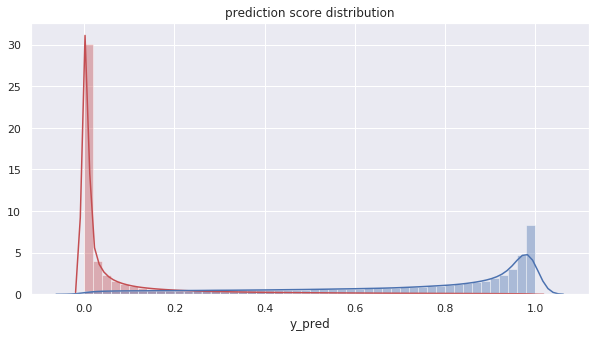

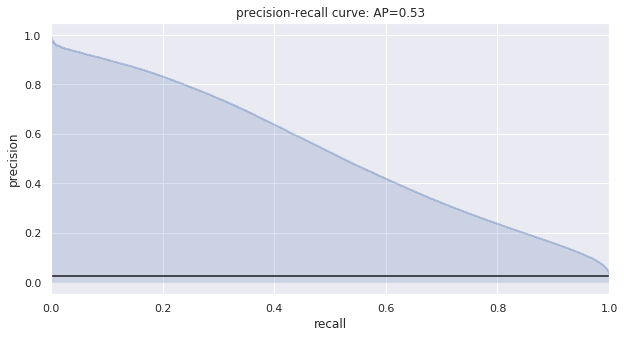

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_212813.pkl
save model to  /home/dmig/work/upsell/result/_0706_212813.pkl
elapsed time:  467.6122422218323
test ym:  201903
load data
df_mart:  (18580984, 81)
make test data format
x_test:  (18580984, 79)
y_test:  (18580984, 1)
evaluation


acc    recall  precision  f1_score       auc
0  0.938392  0.640641   0.231551  0.340157  0.915276

pred: 1   pred: 0
true: 1   295064    165512
true: 0   979231  17141177

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

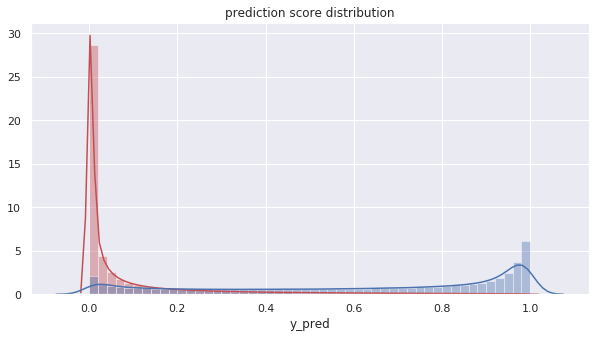

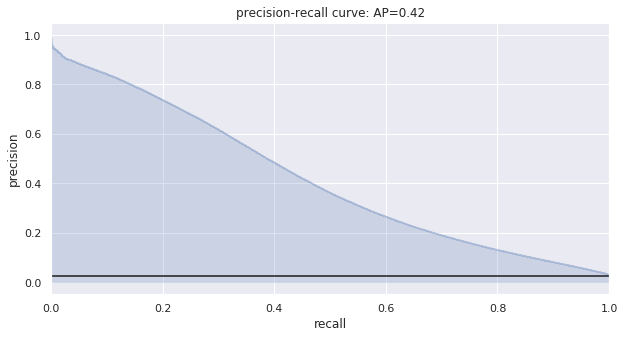

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_213635.pkl
save model to  /home/dmig/work/upsell/result/_0706_213635.pkl
elapsed time:  480.009489774704
test ym:  201904
load data
df_mart:  (18626176, 81)
make test data format
x_test:  (18626176, 79)
y_test:  (18626176, 1)
evaluation


acc    recall  precision  f1_score       auc
0  0.930849  0.525431   0.203882  0.293772  0.865778

pred: 1   pred: 0
true: 1   267890    241958
true: 0  1046057  17070271

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

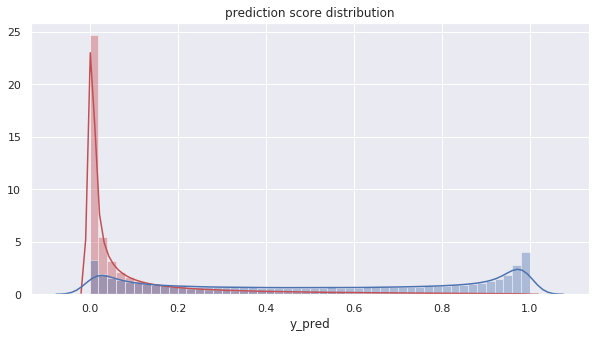

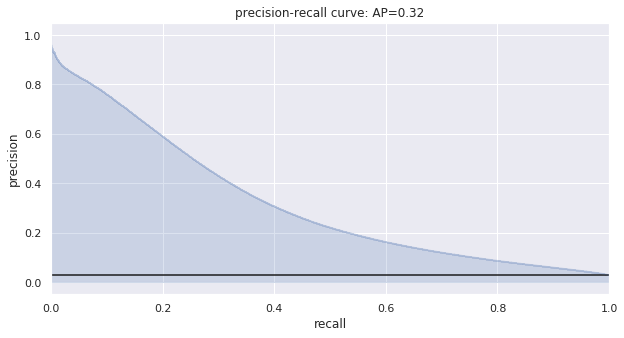

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_214523.pkl
save model to  /home/dmig/work/upsell/result/_0706_214523.pkl
elapsed time:  497.97445821762085
test ym:  201905
load data
df_mart:  (18707537, 81)
make test data format
x_test:  (18707537, 79)
y_test:  (18707537, 1)
evaluation


acc    recall  precision  f1_score       auc
0  0.723645  0.448317   0.038141    0.0703  0.643686

pred: 1   pred: 0
true: 1   195465    240532
true: 0  4929389  13342151

feature   description  importance
44     avg_subscription_period  평균 요금제 변경 주기       75149
5              svc_scrb_period           NaN       71538
49               real_avg_arpu       평균 ARPU       65224
6            last_equip_period           NaN       60402
46             real_arpu_bf_m1       순수 ARPU       44205
48             real_arpu_bf_m3       순수 ARPU       42511
1                          age            나이       42386
3              mng_nice_cb_scr     나이스 신용 점수       39612
47             real_arpu_bf_m2       순수 ARPU       37757
53            data_usage_ratio           NaN       34272
54  bf_m6_data_usage_ratio_avg     데이터 소진 비율       33737
9                  eqp_out_prc        단말 출고가       29996
45            avg_chg_duration      평균 기변 주기       28722
28      data_usage_in_gb_bf_m2     총 데이터 사용량       27229
26      data_usage_in_gb_bf_m0           NaN       26908
27      data_usage_in_gb_bf_m1     총 데이터 사용량       26316
17          avg_twld_visit_cnt  평균 티월드 방문 횟수       21703
7                  bas_fee_amt        요금제 가격       21514
14        twld_visit_cnt_bf_m0           NaN       20010
11               pmth_inv_bamt     전월 잔여 할부금       18936

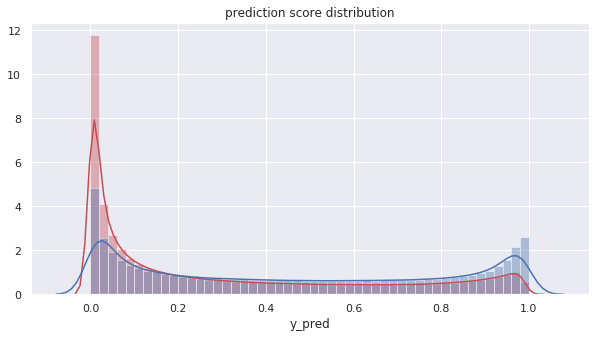

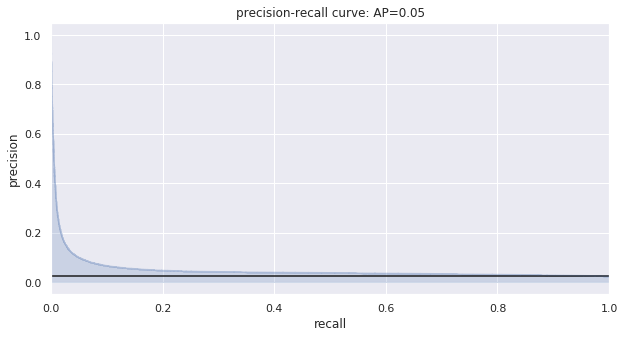

--------------------------------------------------
result dictionary save to /home/dmig/work/upsell/result/_0706_215416.pkl
save model to  /home/dmig/work/upsell/result/_0706_215416.pkl
elapsed time:  500.64888215065


In [66]:
for p in test_period_list:
    test_different_period(clf, p)

In [67]:
for test_ym in test_period_list:
    # load data
    print('load data')
    df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format(test_ym)))
    print('df_mart: ', df_mart.shape)
    print('target ratio: ', df_mart['label'].sum()/df_mart.shape[0])

load data
df_mart:  (18462905, 81)
target ratio:  0.02588075928463045
load data
df_mart:  (18580984, 81)
target ratio:  0.024787492416978564
load data
df_mart:  (18626176, 81)
target ratio:  0.027372660926214806
load data
df_mart:  (18707537, 81)
target ratio:  0.023305954172374483


In [68]:
test_ym = '201901'
df_mart = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_{}.pkl'.format(test_ym)))
print('df_mart: ', df_mart.shape)
print('target ratio: ', df_mart['label'].sum()/df_mart.shape[0])

df_mart:  (18176215, 81)
target ratio:  0.018491913745518524


## 월별 주요 feature 비교
- 1월 vs 5월

In [69]:
# load data
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

df_mart01.shape, df_mart05.shape

((18176215, 81), (18707537, 81))

In [95]:
df_mart03 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201903.pkl'))
df_mart03.shape

(18580984, 81)

In [128]:
def show_difference_between_three_months(m1, m2, m3, col, log_yn = False):
    
    tmp1 = m1[[col, 'label']]
    tmp2 = m2[[col, 'label']]
    tmp3 = m3[[col, 'label']]
    
    if log_yn:
        tmp1[col] = np.log1p(tmp1[col])
        tmp2[col] = np.log1p(tmp2[col])
        tmp3[col] = np.log1p(tmp3[col])
    
    sns.set(rc={'figure.figsize': (21,7)})

    plt.subplot(1,3,1)
    sns.distplot(m1[m1['label']==0][col], norm_hist=True, color='r', label='label: 0')
    sns.distplot(m1[m1['label']==1][col], norm_hist=True, color='b', label='label: 1')



    plt.subplot(1,3,2)
    sns.distplot(m2[m2['label']==0][col], norm_hist=True, color='r', label='label: 0')
    sns.distplot(m2[m2['label']==1][col], norm_hist=True, color='b', label='label: 1')
    
    
    plt.subplot(1,3,3)
    sns.distplot(m3[m3['label']==0][col], norm_hist=True, color='r', label='label: 0')
    sns.distplot(m3[m3['label']==1][col], norm_hist=True, color='b', label='label: 1')
    
    plt.show()

In [105]:
list(df_kor_fea.head(10).feature.values)

['avg_subscription_period',
 'real_avg_arpu',
 'svc_scrb_period',
 'last_equip_period',
 'real_arpu_bf_m1',
 'real_arpu_bf_m3',
 'real_arpu_bf_m2',
 'age',
 'bas_fee_amt',
 'data_usage_ratio']

In [106]:
importance_top_10 = list(df_kor_fea.head(10).feature.values)

In [144]:
for col in importance_top_30:
    print('='*50)
    print('col: ', col)
    print('mart1: ', df_mart01[df_mart01[col]==0].groupby('label')[col].size())
    print('mart3: ', df_mart03[df_mart03[col]==0].groupby('label')[col].size())
    print('mart5: ', df_mart05[df_mart05[col]==0].groupby('label')[col].size())

col:  avg_subscription_period
mart1:  label
0    9275
1     731
Name: avg_subscription_period, dtype: int64
mart3:  label
0    6472
1     929
Name: avg_subscription_period, dtype: int64
mart5:  label
0    6293
1     712
Name: avg_subscription_period, dtype: int64
col:  real_avg_arpu
mart1:  label
0    828506
1       150
Name: real_avg_arpu, dtype: int64
mart3:  label
0    863549
1       148
Name: real_avg_arpu, dtype: int64
mart5:  label
0    898874
1      2579
Name: real_avg_arpu, dtype: int64
col:  svc_scrb_period
mart1:  label
0    6536
1      72
Name: svc_scrb_period, dtype: int64
mart3:  Series([], Name: svc_scrb_period, dtype: int64)
mart5:  label
0    7197
1      98
Name: svc_scrb_period, dtype: int64
col:  last_equip_period
mart1:  label
0    16725
1      146
Name: last_equip_period, dtype: int64
mart3:  Series([], Name: last_equip_period, dtype: int64)
mart5:  label
0    20734
1      216
Name: last_equip_period, dtype: int64
col:  real_arpu_bf_m1
mart1:  label
0    1162340
1  

In [142]:
df_mart01[df_mart01['avg_subscription_period']==0].groupby('label')['avg_subscription_period'].size(), 

(label
 0    9275
 1     731
 Name: avg_subscription_period, dtype: int64, label
 0    6472
 1     929
 Name: avg_subscription_period, dtype: int64)

In [140]:
df_mart03[df_mart03['avg_subscription_period']==0].groupby('label')['avg_subscription_period'].size()

label
0    6472
1     929
Name: avg_subscription_period, dtype: int64

In [141]:
df_mart05[df_mart05['avg_subscription_period']==0].groupby('label')['avg_subscription_period'].size()

label
0    6293
1     712
Name: avg_subscription_period, dtype: int64

col:  avg_subscription_period


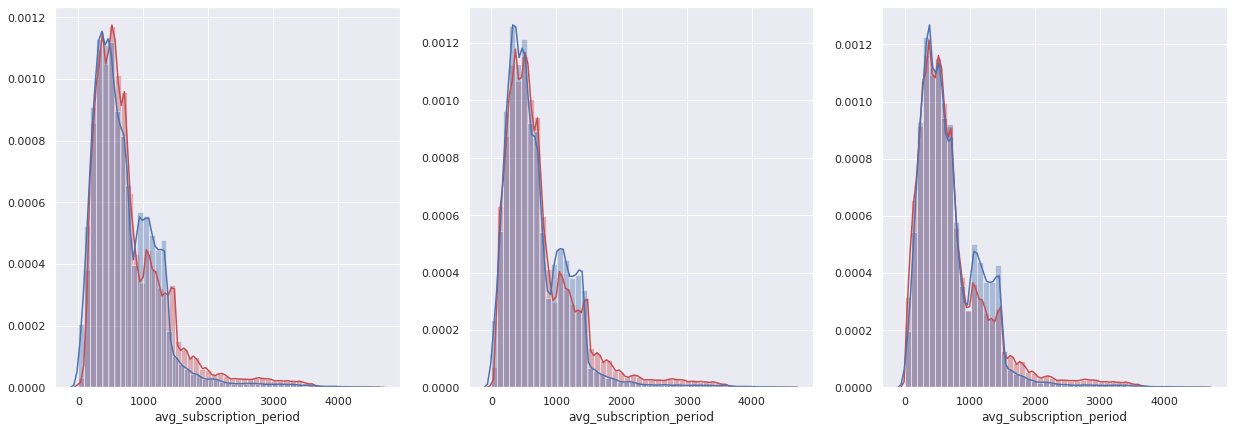

col:  real_avg_arpu


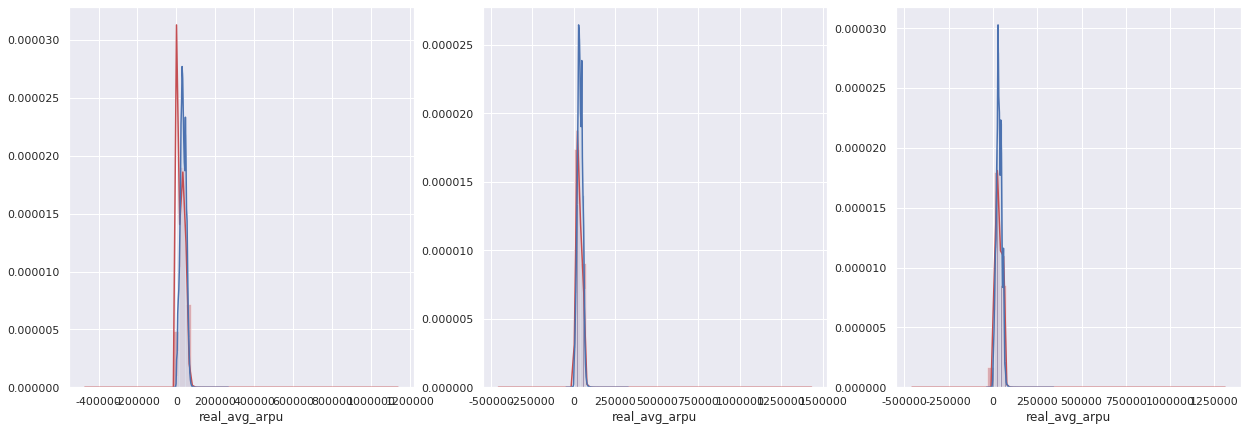

col:  svc_scrb_period


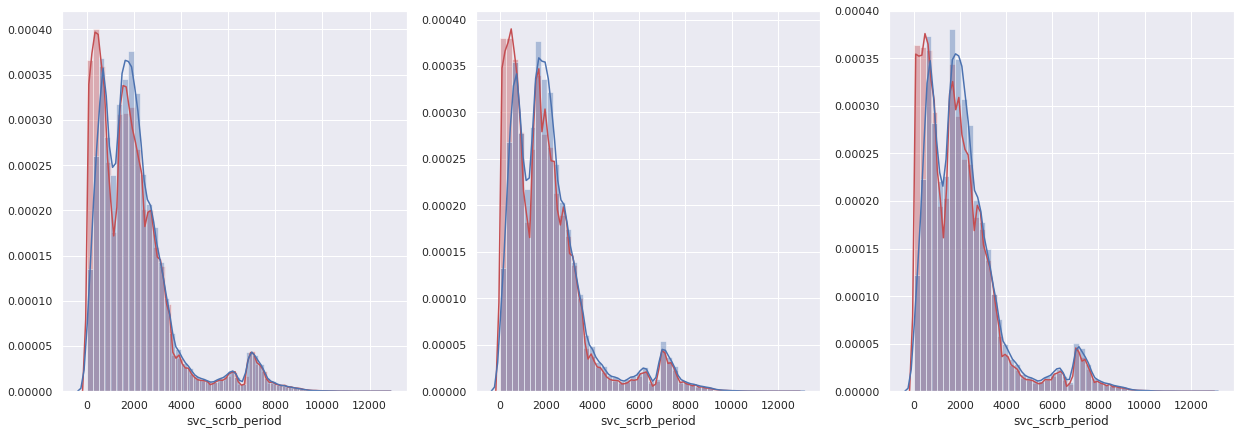

col:  last_equip_period


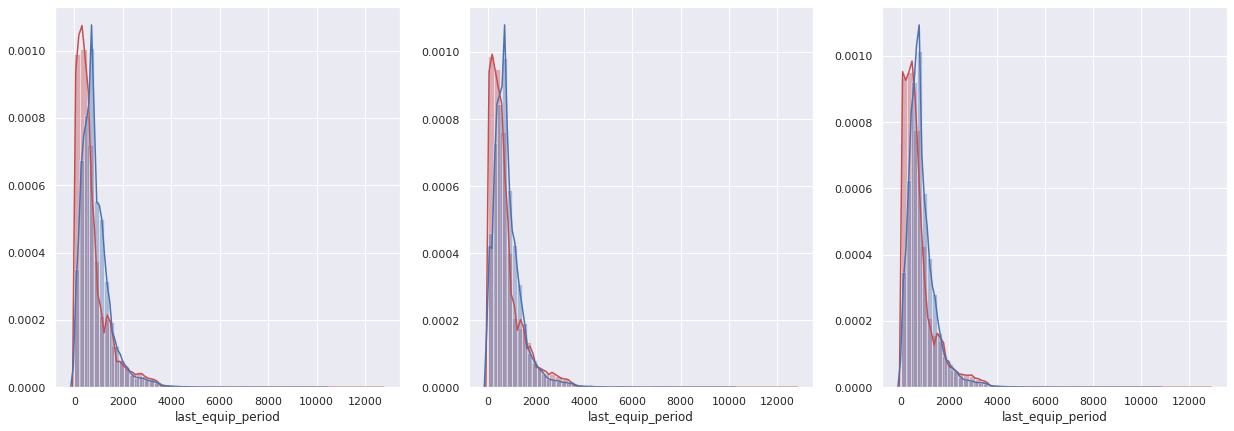

col:  real_arpu_bf_m1


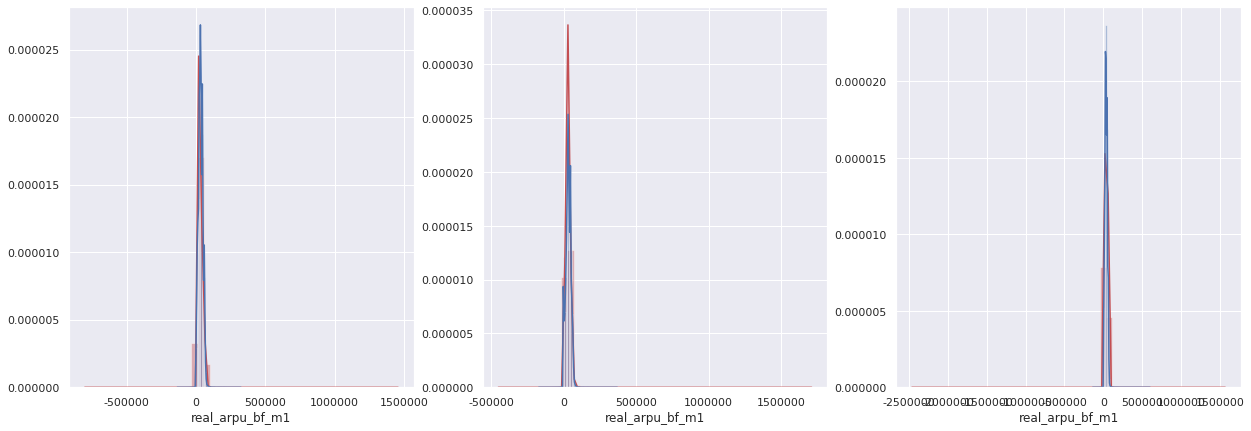

col:  real_arpu_bf_m3


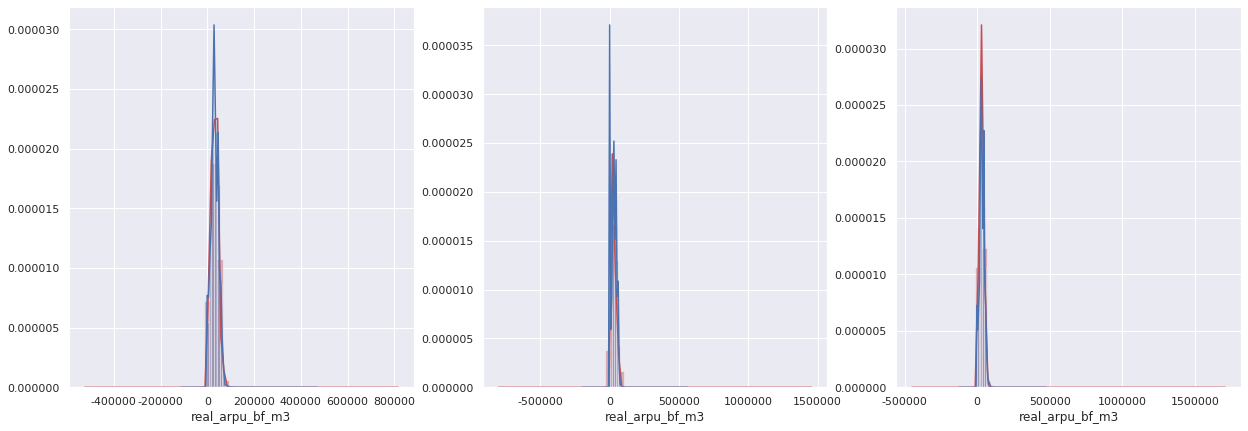

col:  real_arpu_bf_m2


col:  age


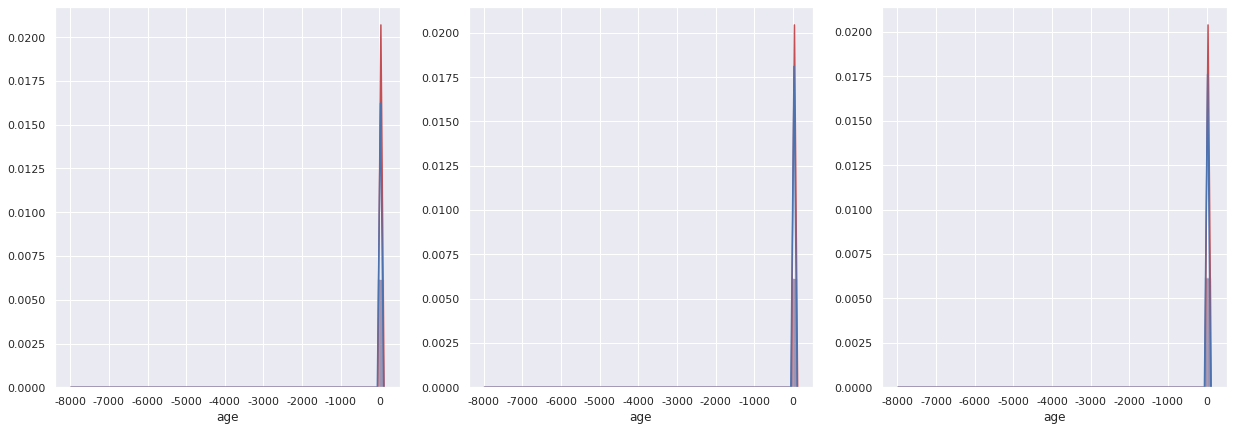

col:  bas_fee_amt


col:  data_usage_ratio


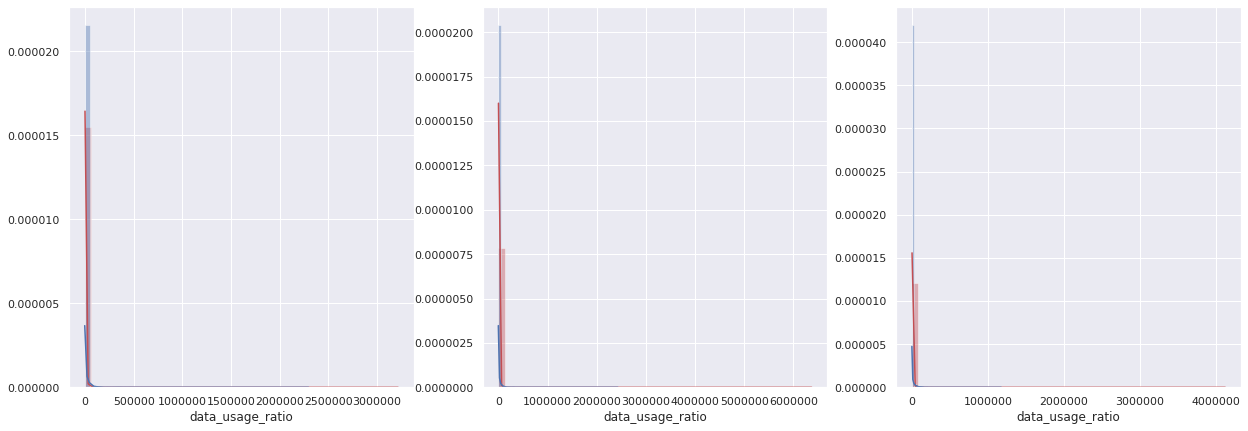

In [107]:
for col in importance_top_10:
    print('='*50)
    print('col: ', col)
    show_difference_between_three_months(df_mart01, df_mart03, df_mart05, col)

In [116]:
df_kor_fea.head()

feature  importance                dimension   description
0  avg_subscription_period       13482  avg_subscription_period  평균 요금제 변경 주기
1            real_avg_arpu       11210            real_avg_arpu       평균 ARPU
2          svc_scrb_period       11084                      NaN           NaN
3        last_equip_period        8450                      NaN           NaN
4          real_arpu_bf_m1        6870          real_arpu_bf_m1       순수 ARPU

In [114]:
importance_top_30 = list(df_kor_fea.head(30).feature.values)

In [131]:
df_kor_fea.head(50)

feature  importance                   dimension  \
0      avg_subscription_period       13482     avg_subscription_period   
1                real_avg_arpu       11210               real_avg_arpu   
2              svc_scrb_period       11084                         NaN   
3            last_equip_period        8450                         NaN   
4              real_arpu_bf_m1        6870             real_arpu_bf_m1   
5              real_arpu_bf_m3        5176             real_arpu_bf_m3   
6              real_arpu_bf_m2        4922             real_arpu_bf_m2   
7                          age        4413                         age   
8                  bas_fee_amt        4266                 bas_fee_amt   
9             data_usage_ratio        2982                         NaN   
10            avg_chg_duration        2862            avg_chg_duration   
11  bf_m6_data_usage_ratio_avg        2822  bf_m6_data_usage_ratio_avg   
12             mng_nice_cb_scr        2705             mng_nice_cb_scr   
13                 eqp_out_prc        2675                 eqp_out_prc   
14             bas_ofr_data_gb        2333                         NaN   
15      data_usage_in_gb_bf_m2        2254      data_usage_in_gb_bf_m2   
16      data_usage_in_gb_bf_m0        2225                         NaN   
17      data_usage_in_gb_bf_m1        2158      data_usage_in_gb_bf_m1   
18           bf_m3_fee_chg_cnt        1979           bf_m3_fee_chg_cnt   
19               pmth_inv_bamt        1795               pmth_inv_bamt   
20               allot_prn_amt        1671               allot_prn_amt   
21        twld_visit_cnt_bf_m0        1614                         NaN   
22        avg_data_usage_in_gb        1591        avg_data_usage_in_gb   
23          avg_twld_visit_cnt        1583          avg_twld_visit_cnt   
24                     channel        1525                     channel   
25  bf_m6_sum_data_usage_in_gb        1476  bf_m6_sum_data_usage_in_gb   
26        twld_visit_cnt_bf_m2        1452        twld_visit_cnt_bf_m2   
27        twld_visit_cnt_bf_m1        1441        twld_visit_cnt_bf_m1   
28  bf_m6_avg_data_usage_in_gb        1418  bf_m6_avg_data_usage_in_gb   
29             avg_mbr_use_cnt        1233             avg_mbr_use_cnt   
30           copn_left_cnt_bf1         928           copn_left_cnt_bf1   
31           copn_left_cnt_bf2         925           copn_left_cnt_bf2   
32           copn_left_cnt_bf0         918                         NaN   
33                 overage_bf0         767                         NaN   
34      avg_twld_fee_visit_cnt         705      avg_twld_fee_visit_cnt   
35                 overage_bf1         627                 overage_bf1   
36                 overage_bf2         570                 overage_bf2   
37    twld_fee_visit_cnt_bf_m0         521                         NaN   
38   bf_m6_data_over_usage_cnt         508   bf_m6_data_over_usage_cnt   
39  ref_data_usage_in_gb_bf_m2         504  ref_data_usage_in_gb_bf_m2   
40             mng_nice_cb_grd         443             mng_nice_cb_grd   
41          mth_cnsl_cnt_bf_m0         439                         NaN   
42                   family_yn         415                   family_yn   
43                    ansim_yn         415                         NaN   
44    twld_fee_visit_cnt_bf_m1         374    twld_fee_visit_cnt_bf_m1   
45  ref_data_usage_in_gb_bf_m0         373                         NaN   
46                      sex_cd         354                      sex_cd   
47    twld_fee_visit_cnt_bf_m2         335    twld_fee_visit_cnt_bf_m2   
48                      svc_gr         316                         NaN   
49          mth_cnsl_cnt_bf_m2         315          mth_cnsl_cnt_bf_m2   

             description  
0           평균 요금제 변경 주기  
1                평균 ARPU  
2                    NaN  
3                    NaN  
4                순수 ARPU  
5                순수 ARPU  
6                순수 ARPU  
7                     나이  
8    

In [115]:
pd.DataFrame({
    'mean01': df_mart01[importance_top_30].mean(),
    'mean03': df_mart03[importance_top_30].mean(),
    'mean05': df_mart05[importance_top_30].mean(),
    
    
    'std01': df_mart01[importance_top_30].std(),
    'std03': df_mart03[importance_top_30].std(),
    'std04': df_mart05[importance_top_30].std(),
})

mean01         mean03         mean05  \
avg_subscription_period        795.034748     759.559113     723.838274   
real_avg_arpu                30192.186805   29949.005962   29794.748923   
svc_scrb_period               1901.880463    1916.870064    1955.103931   
last_equip_period              708.400654     714.050972     724.787527   
real_arpu_bf_m1              29830.668436   29284.883277   29584.726850   
real_arpu_bf_m3              29536.140890   29008.796088   28383.473553   
real_arpu_bf_m2              29678.817276   29119.385645   28961.719136   
age                             42.923917      42.917078      43.031411   
bas_fee_amt                  42064.766091   42151.836932   42613.419139   
data_usage_ratio               678.014233     689.915556     705.606481   
avg_chg_duration               317.836065      87.318126      94.049587   
bf_m6_data_usage_ratio_avg       1.451320       1.411568       1.421652   
mng_nice_cb_scr                805.990653     806.120724     808.885575   
eqp_out_prc                 611206.466772  609822.500619  624495.344971   
bas_ofr_data_gb                 41.407027      45.656772      84.522711   
data_usage_in_gb_bf_m2           7.247213       7.671701       8.076939   
data_usage_in_gb_bf_m0           7.879346       8.288652       9.331889   
data_usage_in_gb_bf_m1           7.517346       7.315418       8.472730   
bf_m3_fee_chg_cnt                0.152465       0.155620       0.166944   
pmth_inv_bamt               197520.210815  192630.527479  188833.265303   
allot_prn_amt               353444.087089  355243.375573  356012.580746   
twld_visit_cnt_bf_m0            30.726837      30.730924       3.877377   
avg_data_usage_in_gb             7.711928       7.838649       8.740016   
avg_twld_visit_cnt              36.771707      36.981541      29.348770   
channel                          2.601070       2.576827       2.575042   
bf_m6_sum_data_usage_in_gb      43.742664      44.669976      47.573355   
twld_visit_cnt_bf_m2            28.835072      29.921775      29.967284   
twld_visit_cnt_bf_m1            29.763339      28.227120      15.276175   
bf_m6_avg_data_usage_in_gb       7.555669       7.747224       8.246307   
avg_mbr_use_cnt                  0.712337       0.702673       0.711110   

                                    std01          std03          std04  
avg_subscription_period        583.406401     580.985652     578.750511  
real_avg_arpu                16661.383993   16847.155153   17097.196914  
svc_scrb_period               1664.894247    1675.833126    1697.918130  
last_equip_period              678.594541     681.349658     685.976016  
real_arpu_bf_m1              17642.500694   17621.072208   17737.879971  
real_arpu_bf_m3              18041.121149   18061.656370   18053.785848  
real_arpu_bf_m2              17851.770743   17832.972632   17929.867296  
age                             32.658473      32.505920      31.643838  
bas_fee_amt                  22076.507462   22192.719363   22608.713599  
data_usage_ratio              7409.919804    7784.685298    7778.499443  
avg_chg_duration              1042.959229     713.716819     714.793829  
bf_m6_data_usage_ratio_avg       3.008583       3.071660       3.143052  
mng_nice_cb_scr                187.335237     190.987782     186.718839  
eqp_out_prc                 344398.542661  345036.489227  360526.735877  
bas_ofr_data_gb                376.888224     389.799825     575.108902  
data_usage_in_gb_bf_m2          16.124553      17.607634      17.927405  
data_usage_in_gb_bf_m0          17.794461      18.097625      19.674766  
data_usage_in_gb_bf_m1          16.900708      16.254263      18.306707  
bf_m3_fee_chg_cnt                0.390435       0.395931       0.410179  
pmth_inv_bamt               330218.306120  325581.850487  324747.798597  
allot_prn_amt               473097.206518  477570.505926  483214.083506  
twld_visit_cnt_bf_m0           146.523527     206.689088      33.093486  
avg_dat

In [118]:
target_cols = ['avg_chg_duration', 'bas_ofr_data_gb', 'twld_visit_cnt_bf_m0']

In [125]:
df_kor_fea[df_kor_fea['feature'].isin(target_cols)]

feature  importance         dimension description
10      avg_chg_duration        2862  avg_chg_duration    평균 기변 주기
14       bas_ofr_data_gb        2333               NaN         NaN
21  twld_visit_cnt_bf_m0        1614               NaN         NaN

## TARGET_COLS 제외하고 training

## 어떤 컬럼일까??

In [ ]:
분석동의 적용 로직

## prediction score distribution 살펴보면???

## shap

In [145]:
import shap

In [146]:
shap.initjs()

In [147]:
clf

In [148]:
explainer = shap.TreeExplainer(clf)

In [ ]:
shap_values = explainer.shap_values(x_trn)

In [ ]:
trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']


val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

trn_idx.shape, x_trn.shape, y_trn.shape, val_idx.shape, x_val.shape, y_val.shape